## cfos_batch_combination_spatial
The purpose of this notebook is to do some exploratory data analysis to try to visualize and ultimately understand what is causing the differences in fractional counts between c-Fos brains from different batches

In [3]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from cloudvolume import CloudVolume
import edt

%matplotlib inline

In [4]:
PCA_subset_file = '../data/202002_cfos_subset_PCA_groups.csv'
main_file = '../data/animals_counts.csv'
pivot_file = '../data/pivot.csv'
pma_segment_props_file = '../data/pma_segment_properties_info'

In [5]:
main_df = pd.read_csv(main_file)
main_df

,Brain,Condition,experiment,Peripeduncular nucleus,Parabigeminal nucleus,Pedunculopontine nucleus,"Substantia nigra, compact part",Inferior colliculus,"Midbrain reticular nucleus, retrorubral area",Nucleus sagulum,...,external medullary lamina of the thalamus,genu of corpus callosum,inferior cerebellar peduncle,commissural branch of stria terminalis,dorsal spinocerebellar tract,cerebellar commissure,genu of the facial nerve,direct tectospinal pathway,cuneate fascicle,pyramidal decussation
0,dadult_pc_crus1_8,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,0,26,50,4,0,...,0,0,0,0,0,0,0,0,0,0
1,dadult_pc_crus1_9,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,1,2,0,9,6,4,...,0,0,0,0,0,0,0,0,0,0
2,dadult_pc_crus1_5,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,9,13,10,46,23,8,...,0,0,0,0,0,0,0,0,0,0
3,dadult_pc_crus1_6,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,7,33,8,6,68,...,0,0,0,0,0,0,0,0,0,0
4,dadult_pc_crus1_2,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0,2,1,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,an026,acquisition_day2,ymaze_learning,4,5,108,88,1,1,24,...,2,4,15,2241,1,86,1,0,0,0
154,an027,acquisition_day2,ymaze_learning,23,11,529,91,7,173,20,...,7,103,58,3292,0,7,0,0,0,0
155,an028,acquisition_day2,ymaze_learning,13,4,570,30,0,280,129,...,5,298,43,3013,31,5,0,0,0,0
156,an029,acquisition_day2,ymaze_learning,29,2,51,0,1,1,8,...,2,20,0,2055,0,0,0,0,0,0


This file has the brain, condition, experiment (aka batch) and then c-fos cell counts in each brain region. I am assuming these are the Princeton Mouse Atlas regions since that is what Jess typically uses. Quick way to tell is seeing if the regions Tom added to PMA are in the columns

In [6]:
[x for x in main_df.columns if 'Declive (VI)' in x]

['Declive (VI), subdivision A', 'Declive (VI), subdivision B']

Only the PMA has subdivision B so this must be PMA

OK, so what we need to do is figure out fractional counts in each region

In [7]:
# first calculate sum of counts in each row and put in a new column
main_df['sumcounts'] = main_df.iloc[:,3:].sum(axis=1)
main_df

,Brain,Condition,experiment,Peripeduncular nucleus,Parabigeminal nucleus,Pedunculopontine nucleus,"Substantia nigra, compact part",Inferior colliculus,"Midbrain reticular nucleus, retrorubral area",Nucleus sagulum,...,genu of corpus callosum,inferior cerebellar peduncle,commissural branch of stria terminalis,dorsal spinocerebellar tract,cerebellar commissure,genu of the facial nerve,direct tectospinal pathway,cuneate fascicle,pyramidal decussation,sumcounts
0,dadult_pc_crus1_8,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,0,26,50,4,0,...,0,0,0,0,0,0,0,0,0,64608
1,dadult_pc_crus1_9,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,1,2,0,9,6,4,...,0,0,0,0,0,0,0,0,0,61296
2,dadult_pc_crus1_5,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,9,13,10,46,23,8,...,0,0,0,0,0,0,0,0,0,57416
3,dadult_pc_crus1_6,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,1,0,7,33,8,6,68,...,0,0,0,0,0,0,0,0,0,54041
4,dadult_pc_crus1_2,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0,2,1,1,2,2,2,...,0,0,0,0,0,0,0,0,0,50338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,an026,acquisition_day2,ymaze_learning,4,5,108,88,1,1,24,...,4,15,2241,1,86,1,0,0,0,299872
154,an027,acquisition_day2,ymaze_learning,23,11,529,91,7,173,20,...,103,58,3292,0,7,0,0,0,0,429789
155,an028,acquisition_day2,ymaze_learning,13,4,570,30,0,280,129,...,298,43,3013,31,5,0,0,0,0,473597
156,an029,acquisition_day2,ymaze_learning,29,2,51,0,1,1,8,...,20,0,2055,0,0,0,0,0,0,192775


In [8]:
sumcounts = main_df['sumcounts']
sumcounts

0       64608
1       61296
2       57416
3       54041
4       50338
        ...  
153    299872
154    429789
155    473597
156    192775
157    215302
Name: sumcounts, Length: 158, dtype: int64

In [9]:
# now replace columns with fractional counts
main_df.iloc[:,3:-1] = main_df.iloc[:,3:-1].apply(lambda x: x/sumcounts)

In [10]:
main_df

,Brain,Condition,experiment,Peripeduncular nucleus,Parabigeminal nucleus,Pedunculopontine nucleus,"Substantia nigra, compact part",Inferior colliculus,"Midbrain reticular nucleus, retrorubral area",Nucleus sagulum,...,genu of corpus callosum,inferior cerebellar peduncle,commissural branch of stria terminalis,dorsal spinocerebellar tract,cerebellar commissure,genu of the facial nerve,direct tectospinal pathway,cuneate fascicle,pyramidal decussation,sumcounts
0,dadult_pc_crus1_8,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0.000015,0.000000,0.000000,0.000402,0.000774,0.000062,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,64608
1,dadult_pc_crus1_9,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0.000016,0.000016,0.000033,0.000000,0.000147,0.000098,0.000065,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,61296
2,dadult_pc_crus1_5,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0.000017,0.000157,0.000226,0.000174,0.000801,0.000401,0.000139,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,57416
3,dadult_pc_crus1_6,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0.000019,0.000000,0.000130,0.000611,0.000148,0.000111,0.001258,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,54041
4,dadult_pc_crus1_2,crusI_bilateral_reversal,201810_adultacutePC_ymaze_cfos,0.000000,0.000040,0.000020,0.000020,0.000040,0.000040,0.000040,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,50338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,an026,acquisition_day2,ymaze_learning,0.000013,0.000017,0.000360,0.000293,0.000003,0.000003,0.000080,...,0.000013,0.000050,0.007473,0.000003,0.000287,0.000003,0.0,0.0,0.0,299872
154,an027,acquisition_day2,ymaze_learning,0.000054,0.000026,0.001231,0.000212,0.000016,0.000403,0.000047,...,0.000240,0.000135,0.007660,0.000000,0.000016,0.000000,0.0,0.0,0.0,429789
155,an028,acquisition_day2,ymaze_learning,0.000027,0.000008,0.001204,0.000063,0.000000,0.000591,0.000272,...,0.000629,0.000091,0.006362,0.000065,0.000011,0.000000,0.0,0.0,0.0,473597
156,an029,acquisition_day2,ymaze_learning,0.000150,0.000010,0.000265,0.000000,0.000005,0.000005,0.000041,...,0.000104,0.000000,0.010660,0.000000,0.000000,0.000000,0.0,0.0,0.0,192775


OK so we have fractional counts in there now. Now let's focus on trying to visualize these as a heatmap in atlas space. What we will need to do that is an x,y,z centroid for each of these regions in a new dataframe. We have the 16 bit PMA volume so let's use that as it will be faster to index. Then we need a mapping between region name and the ID in the 16 bit PMA volume. We can get this mapping from the segment_properties folder of the Neuroglancer layer. 

In [11]:
with open(pma_segment_props_file,'r') as infile:
    pma_segment_props = json.load(infile)
pma_segment_props

{'@type': 'neuroglancer_segment_properties',
 'inline': {'ids': ['1',
   '2',
   '3',
   '4',
   '5',
   '6',
   '7',
   '8',
   '9',
   '10',
   '11',
   '12',
   '13',
   '14',
   '15',
   '16',
   '17',
   '18',
   '19',
   '20',
   '21',
   '22',
   '23',
   '24',
   '25',
   '26',
   '27',
   '28',
   '29',
   '30',
   '31',
   '32',
   '33',
   '34',
   '35',
   '36',
   '37',
   '38',
   '39',
   '40',
   '41',
   '42',
   '43',
   '44',
   '45',
   '46',
   '47',
   '48',
   '49',
   '50',
   '51',
   '52',
   '53',
   '54',
   '55',
   '56',
   '57',
   '58',
   '59',
   '60',
   '61',
   '62',
   '63',
   '64',
   '65',
   '66',
   '67',
   '68',
   '69',
   '70',
   '71',
   '72',
   '73',
   '74',
   '75',
   '76',
   '77',
   '78',
   '79',
   '80',
   '81',
   '82',
   '83',
   '84',
   '85',
   '86',
   '87',
   '88',
   '89',
   '90',
   '91',
   '92',
   '93',
   '94',
   '95',
   '96',
   '97',
   '98',
   '99',
   '100',
   '101',
   '102',
   '103',
   '104',
   '10

In [12]:
ids = pma_segment_props['inline']['ids']
regions_withacronyms = pma_segment_props['inline']['properties'][0]['values']
region_names = [''.join(x.split(':')[1:]).strip() for x in regions_withacronyms]
pma_id_dict = {ids[ii]:region_names[ii] for ii in range(len(ids)) if region_names[ii] in main_df.columns[3:]}
pma_id_dict

{'1': 'root',
 '4': 'Midbrain',
 '5': 'Midbrain, motor related',
 '6': 'Oculomotor nucleus',
 '7': 'Medial terminal nucleus of the accessory optic tract',
 '8': 'Lateral terminal nucleus of the accessory optic tract',
 '9': 'Dorsal terminal nucleus of the accessory optic tract',
 '10': 'Trochlear nucleus',
 '11': 'Midbrain reticular nucleus',
 '15': 'Red nucleus',
 '16': 'Anterior tegmental nucleus',
 '17': 'Midbrain reticular nucleus, retrorubral area',
 '18': 'Superior colliculus, motor related',
 '19': 'Superior colliculus, motor related, intermediate gray layer',
 '20': 'Superior colliculus, motor related, intermediate gray layer, sublayer a',
 '21': 'Superior colliculus, motor related, intermediate gray layer, sublayer b',
 '23': 'Superior colliculus, motor related, intermediate white layer',
 '24': 'Superior colliculus, motor related, deep gray layer',
 '25': 'Superior colliculus, motor related, deep white layer',
 '26': 'Substantia nigra, reticular part',
 '28': 'Cuneiform nucle

This dictionary maps the ids to region names for ONLY the regions that are in the count dataframe. 

In [13]:
len(pma_id_dict)

664

In [14]:
# Now figure out x,y,z centroid of each of these regions in the registered PMA space
pma_16bit_vol = CloudVolume('file:///home/ahoag/ngdemo/demo_bucket/atlas/princetonmouse_16bit_hierarch_labels/',
                           parallel=True)
pma_16bit_data = np.transpose(pma_16bit_vol[:][...,0],(2,1,0))

# first load the PMA 16-bit volume using cloud-volume

Downloading: 100%|██████████| 45/45 [00:00<00:00, 354.16it/s]













In [15]:
pma_16bit_data.shape

(540, 640, 352)

In [16]:
mask = pma_16bit_data == 4

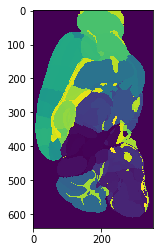

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(pma_16bit_data[200])

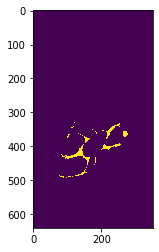

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(mask[200])

# z,y,x
266 392 266
(540, 640, 352)


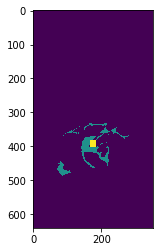

In [19]:
# to get the centroid in 3d we need all voxels where the mask is 1
mask = (pma_16bit_data == 4).astype('uint16')
meanx,meany,meanz=np.mean(np.where(mask),axis=1)
meanz,meany,meanx = [int(round(x)) for x in [meanx,meany,meanz]]
spread = 10
print("# z,y,x")
print(meanz,meany,meanz)
print(mask.shape)
mask[meanz-spread:meanz+spread,meany-spread:meany+spread,meanx-spread:meanx+spread] = 2
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(mask[266])


In [145]:
# OK, this is clearly the center.
# Now go through and find the center for each region 
# and store in a dataframe
pma_centroid_dict = {}
for ii,region_id in enumerate(pma_id_dict):
    print(ii+1,"/",len(pma_id_dict))
    mask = (pma_16bit_data == int(region_id))
    try:
        meanx,meany,meanz=np.mean(np.where(mask),axis=1)
        meanz,meany,meanx = [int(round(x)) for x in [meanx,meany,meanz]]
        pma_centroid_dict[region_id] = (meanx,meany,meanz)
    except:
        print("didn't find any voxels for region: ",region_id)
        pma_centroid_dict[region_id] = (-999,-999,-999)

1 / 664
2 / 664
3 / 664
didn't find any voxels for region:  5
4 / 664
5 / 664
6 / 664
7 / 664
8 / 664
9 / 664
10 / 664
11 / 664
12 / 664
13 / 664
didn't find any voxels for region:  18
14 / 664
15 / 664
16 / 664
17 / 664
18 / 664
19 / 664
20 / 664
21 / 664
22 / 664
23 / 664
24 / 664
25 / 664
26 / 664
27 / 664
28 / 664
29 / 664
30 / 664
didn't find any voxels for region:  37
31 / 664
32 / 664
33 / 664
34 / 664
35 / 664
36 / 664
37 / 664
38 / 664
didn't find any voxels for region:  49
39 / 664
40 / 664
41 / 664
42 / 664
43 / 664
44 / 664
didn't find any voxels for region:  55
45 / 664
46 / 664
47 / 664
48 / 664
49 / 664
50 / 664
51 / 664
52 / 664
didn't find any voxels for region:  63
53 / 664
didn't find any voxels for region:  64
54 / 664
55 / 664
56 / 664
57 / 664
58 / 664
59 / 664
60 / 664
61 / 664
62 / 664
63 / 664
64 / 664
65 / 664
66 / 664
67 / 664
68 / 664
69 / 664
70 / 664
71 / 664
72 / 664
73 / 664
74 / 664
75 / 664
76 / 664
77 / 664
78 / 664
79 / 664
80 / 664
81 / 664
82 / 664

636 / 664
637 / 664
638 / 664
639 / 664
640 / 664
641 / 664
642 / 664
643 / 664
644 / 664
645 / 664
646 / 664
647 / 664
648 / 664
649 / 664
650 / 664
651 / 664
652 / 664
653 / 664
654 / 664
655 / 664
656 / 664
657 / 664
658 / 664
659 / 664
660 / 664
661 / 664
662 / 664
663 / 664
664 / 664


In [147]:
# Save this dataframe so we never have to recompute it
pma_centroid_df = pd.DataFrame([pma_centroid_dict])
pma_centroid_df

,1,4,5,6,7,8,9,10,11,15,...,1275,1283,1284,1286,1290,1299,1301,1303,1304,1305
0,"(289, 305, 226)","(176, 392, 266)","(-999, -999, -999)","(174, 402, 265)","(238, 365, 265)","(199, 360, 265)","(141, 378, 268)","(176, 428, 265)","(181, 395, 266)","(198, 382, 265)",...,"(289, 291, 262)","(181, 329, 263)","(124, 320, 264)","(178, 254, 264)","(236, 302, 264)","(279, 459, 266)","(214, 379, 264)","(259, 468, 268)","(189, 397, 270)","(194, 391, 265)"


In [171]:
pma_centroid_df.to_csv('../data/pma_centroids_xyz.csv')

In [163]:
# now that we have the centroid dict we want to first make a 2d scatter plot in a single brain slice
# where the size or color of the point is correlated to the fractional counts

# Let's pick just one brain in the dataframe to start
test_brain_series = main_df[main_df['experiment']=='202002_cfos'].iloc[0]
test_brain_series

Brain                         an5_cno_injection_only
Condition                         cno_injection_only
experiment                               202002_cfos
Peripeduncular nucleus                             0
Parabigeminal nucleus                     0.00010168
                                       ...          
genu of the facial nerve                           0
direct tectospinal pathway                         0
cuneate fascicle                                   0
pyramidal decussation                              0
sumcounts                                    7179408
Name: 76, Length: 668, dtype: object

In [167]:
# Need to put the fractional count data into a dict mapping region name to val
frac_count_dict={test_brain_series.index[ii]:test_brain_series.values[ii] for ii in range(3,len(test_brain_series))}

In [184]:
pma_centroid_dict_cleaned = {key:list(pma_centroid_dict[key]) for key in pma_centroid_dict if -999 not in pma_centroid_dict[key]}
pma_centroid_dict_cleaned

{'1': [289, 305, 226],
 '4': [176, 392, 266],
 '6': [174, 402, 265],
 '7': [238, 365, 265],
 '8': [199, 360, 265],
 '9': [141, 378, 268],
 '10': [176, 428, 265],
 '11': [181, 395, 266],
 '15': [198, 382, 265],
 '16': [217, 424, 265],
 '17': [209, 396, 266],
 '19': [103, 392, 266],
 '20': [109, 352, 262],
 '21': [151, 348, 269],
 '23': [113, 399, 266],
 '24': [117, 409, 266],
 '25': [118, 411, 266],
 '26': [231, 369, 265],
 '28': [164, 451, 268],
 '29': [231, 365, 264],
 '30': [210, 442, 265],
 '31': [145, 420, 266],
 '32': [151, 332, 264],
 '33': [179, 369, 265],
 '34': [175, 369, 264],
 '35': [161, 410, 266],
 '36': [183, 379, 264],
 '38': [148, 351, 265],
 '39': [110, 348, 265],
 '40': [108, 351, 266],
 '41': [141, 348, 264],
 '42': [117, 341, 264],
 '43': [116, 354, 265],
 '47': [248, 372, 263],
 '50': [75, 454, 269],
 '51': [117, 461, 268],
 '52': [93, 461, 266],
 '53': [110, 456, 267],
 '54': [176, 415, 270],
 '56': [71, 405, 266],
 '57': [71, 407, 267],
 '58': [84, 398, 266],
 '5

In [185]:
pma_centroids_cleaned = list(pma_centroid_dict_cleaned.values())
pma_centroids_cleaned

[[289, 305, 226],
 [176, 392, 266],
 [174, 402, 265],
 [238, 365, 265],
 [199, 360, 265],
 [141, 378, 268],
 [176, 428, 265],
 [181, 395, 266],
 [198, 382, 265],
 [217, 424, 265],
 [209, 396, 266],
 [103, 392, 266],
 [109, 352, 262],
 [151, 348, 269],
 [113, 399, 266],
 [117, 409, 266],
 [118, 411, 266],
 [231, 369, 265],
 [164, 451, 268],
 [231, 365, 264],
 [210, 442, 265],
 [145, 420, 266],
 [151, 332, 264],
 [179, 369, 265],
 [175, 369, 264],
 [161, 410, 266],
 [183, 379, 264],
 [148, 351, 265],
 [110, 348, 265],
 [108, 351, 266],
 [141, 348, 264],
 [117, 341, 264],
 [116, 354, 265],
 [248, 372, 263],
 [75, 454, 269],
 [117, 461, 268],
 [93, 461, 266],
 [110, 456, 267],
 [176, 415, 270],
 [71, 405, 266],
 [71, 407, 267],
 [84, 398, 266],
 [189, 473, 268],
 [152, 395, 266],
 [178, 412, 260],
 [142, 340, 264],
 [225, 380, 264],
 [245, 382, 264],
 [200, 379, 264],
 [204, 402, 265],
 [178, 439, 265],
 [230, 366, 265],
 [200, 430, 267],
 [291, 540, 271],
 [327, 536, 273],
 [258, 497, 277

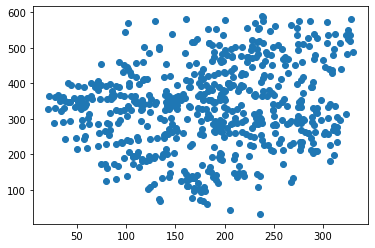

In [196]:
# Let's start by making a scatterplot of just the x and y coordinates of the regions
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter([x[0] for x in pma_centroids_cleaned],[x[1] for x in pma_centroids_cleaned])

In [209]:
# Now let's look at some central slices and loop through a few of them and plot the 
# coordinates of the centroids for regions in that slice and then color code them by fractional count
z=270 # the center z plane
z_tolerance = 5 # the number of z planes on either side to check
z_range = list(range(z-z_tolerance,z+z_tolerance+1))
centroid_dict_this_chunk = {key:pma_centroid_dict_cleaned[key] for key in pma_centroid_dict_cleaned if pma_centroid_dict_cleaned[key][2] in z_range}

In [220]:
frac_counts = np.array([frac_count_dict[pma_id_dict[region_id]] for region_id in centroid_dict_this_chunk])
frac_counts

array([0.00000000e+00, 3.89586439e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.05846944e-02, 2.30771117e-03,
       1.53215975e-06, 1.55444571e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.23310446e-04,
       2.14460579e-03, 3.39860891e-05, 1.76478339e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.25603002e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.39295496e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00398250e-03, 0.00000000e+00,
       0.00000000e+00, 6.78328910e-05, 1.67757564e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [216]:
centroids_this_chunk = np.array(list(centroid_dict_this_chunk.values()))
centroids_this_chunk

array([[176, 392, 266],
       [174, 402, 265],
       [238, 365, 265],
       ...,
       [259, 468, 268],
       [189, 397, 270],
       [194, 391, 265]])

In [229]:
# Make a mask of the boundary of this slice
binary_im = pma_16bit_data[z].astype('bool')
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.imshow(binary_im)
dt = edt.edt(
  binary_im, anisotropy=(1,1), 
  black_border=True, order='C',
  parallel=4 # number of threads, <= 0 sets to num cpu
)
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)

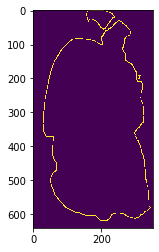

In [238]:
dt_mask = np.logical_and(dt>0,dt<3)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(dt_mask)

(-0.5, 351.5, 639.5, -0.5)

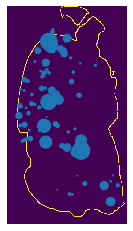

In [259]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# First show the brain boundary
ax.imshow(dt_mask)
ax.scatter(centroids_this_chunk[:,0],centroids_this_chunk[:,1],s=frac_counts*10000)
ax.axis('off')

In [ ]:
# OK, now let's make this same plot for the brains of interest side by side

In [245]:
# Also want to make the radial plots for this brain
zavg,yavg,xavg = [x/2 for x in pma_16bit_data.shape]

In [244]:
centroids_dict_clea

[270.0, 320.0, 176.0]

In [248]:
radial_dist_dict = {} # map region ID to radial distance from center of PMA volume
for region_id in pma_centroid_dict:
    x,y,z = pma_centroid_dict[region_id]
    dst = np.sqrt((x-xavg)**2+(y-yavg)**2+(z-zavg)**2)
    radial_dist_dict[region_id] = dst
radial_dist_dict

{'1': 122.18837915284743,
 '4': 72.11102550927978,
 '5': 2175.0280457961917,
 '6': 82.17663901620703,
 '7': 76.77239087067694,
 '8': 46.411205543489174,
 '9': 67.7716754994297,
 '10': 108.11567878897121,
 '11': 75.27283706623525,
 '15': 65.97726881282674,
 '16': 111.90174261377702,
 '17': 82.95179322956196,
 '18': 2175.0280457961917,
 '19': 102.61091559868278,
 '20': 74.67931440499437,
 '21': 37.54996671103717,
 '23': 101.1236866416568,
 '24': 106.85504199615477,
 '25': 107.98611021793498,
 '26': 73.83088784512888,
 '28': 131.56367279762298,
 '29': 71.31619731870173,
 '30': 126.74778104566565,
 '31': 104.77117924314874,
 '32': 28.372521918222215,
 '33': 49.34571916590131,
 '34': 49.37610758251404,
 '35': 91.32907532653553,
 '36': 59.715994507334464,
 '37': 2175.0280457961917,
 '38': 42.07136793592526,
 '39': 71.8679344353238,
 '40': 74.83982896827064,
 '41': 45.221676218380054,
 '42': 62.91263784010332,
 '43': 69.14477565225012,
 '47': 89.08984229416954,
 '49': 2175.0280457961917,
 '50

In [249]:
radial_dist_dict.keys() == frac_count_dict.keys()

False

In [251]:
frac_counts = np.array([frac_count_dict[pma_id_dict[region_id]] for region_id in radial_dist_dict])


In [252]:
radial_dists = list(radial_dist_dict.values())


(0, 0.02)

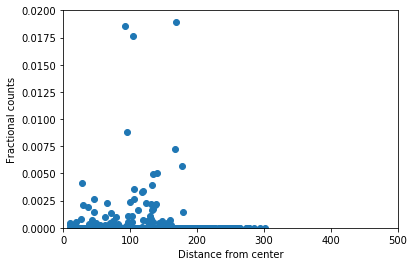

In [258]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(radial_dists,frac_counts)
ax.set_xlabel("Distance from center")
ax.set_ylabel("Fractional counts")
ax.set_xlim(0,500)
ax.set_ylim(0,0.02)

In [ ]:
# dorsal vs. ventral 

# coarse level all neocortex rostral or caudal to somatomotor - thirds of neocortex.All of basal ganglia  - Zahra will send me

# Making box plots of 